In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2,joblib,glob,os
from imutils.object_detection import non_max_suppression
import imutils
from skimage.feature import hog
from skimage import color
from skimage.transform import pyramid_gaussian
import argparse
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_dir = os.path.join('/content/drive','MyDrive/Đồ án CV/')

#Train_SVM

In [ ]:
X = []
Y = []

pos_im_path = os.path.join(root_dir, 'PennFudanPed/datasetforHOG/Positive/')
neg_im_path = os.path.join(root_dir, 'PennFudanPed/datasetforHOG/Negative/')

# Load the positive features
for filename in glob.glob(os.path.join(pos_im_path,"*.jpg")):
    fd = cv2.imread(filename,0)
    fd = cv2.resize(fd,(64,128))
    fd = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    X.append(fd)
    Y.append(1)

# Load the negative features
for filename in glob.glob(os.path.join(neg_im_path,"*.jpg")):
    fd = cv2.imread(filename,0)
    fd = cv2.resize(fd,(64,128))
    fd = hog(fd,orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
    X.append(fd)
    Y.append(0)

X = np.float32(X)
Y = np.array(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

print('Train Data:',len(X_train))
print('Train Labels (1,0)',len(y_train))


model = LinearSVC()
model.fit(X_train,y_train)

# predict
y_pred = model.predict(X_test)

# confusion matrix and accuracy

from sklearn import metrics
from sklearn.metrics import classification_report

print(f"Classification report for classifier {model}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

joblib.dump(model, '/content/drive/MyDrive/Đồ án CV/models.dat')
print('Model saved : {}'.format('models.dat'))

Train Data: 916
Train Labels (1,0) 916
Classification report for classifier LinearSVC():
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       163
           1       0.95      0.84      0.89        67

    accuracy                           0.94       230
   macro avg       0.94      0.91      0.92       230
weighted avg       0.94      0.94      0.94       230


Model saved : models.dat


#Detection

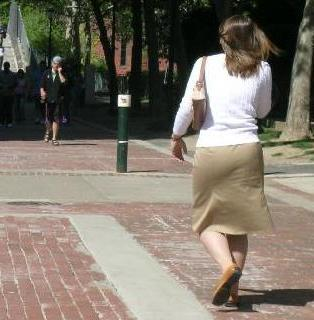

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


sc: [0.950715072598366, 0.7002780281546972, 0.5654587415624355, 0.7162360241274772, 0.60945790604602, 1.4132808015164313, 1.2552298750058202, 0.9515362070408331, 0.5430405338737263, 0.9750858502736297, 0.8444963535725984, 0.5917461624718218, 0.9648766335254471, 0.5621190900156484, 0.7954945511904885, 1.4511147485078144, 1.3944875407374684, 0.5625766974979506, 0.527176713051404, 0.6380645066532862, 1.313937995072662, 1.4884910011632693, 2.201895404548027, 1.451790667993657, 0.9852594661354315, 0.7615608541347487, 0.580783653396159, 0.6746266785324215, 1.614111061499377, 0.8911111631316933, 1.3850489880021797]


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


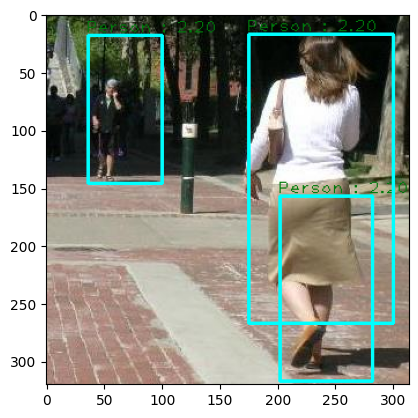

In [27]:
# from google.colab import files

# # Yêu cầu người dùng tải lên một ảnh
# uploaded = files.upload()
# image_path = next(iter(uploaded))
dir_images= os.path.join(root_dir, '/TestImage/')
image_path = '/content/drive/MyDrive/Đồ án CV/Dataset/Test Dataset/image_42.jpg'

size = (64,128)
step_size = (9,9)
downscale = 1.25
# modelfile = os.path.join(root_dir, )
model = joblib.load('/content/drive/MyDrive/Đồ án CV/models.dat')
# for image in images:
image = cv2.imread(image_path)
# image = cv2.resize(image,(300,200))
#List to store the detections
detections = []
#The current scale of the image
scale = 0
cv2_imshow(image)
# define sliding_window function to slide through each area in the image with the size 64x128
def sliding_window(image, window_size, step_size):
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y: y + window_size[1], x: x + window_size[0]])

for im_scaled in pyramid_gaussian(image, downscale = downscale):
        #The list contains detections at the current scale
    if im_scaled.shape[0] < size[1] or im_scaled.shape[1] < size[0]:
        break
    # Extract HOG features from a test image using a sliding window technique.
    for (x, y, window) in sliding_window(im_scaled, size, step_size):
        if window.shape[0] != size[1] or window.shape[1] != size[0]:
            continue
        window = color.rgb2gray(window)

        fd=hog(window, orientations=9,pixels_per_cell=(8,8),visualize=False,cells_per_block=(3,3))
        fd = fd.reshape(1, -1)
        pred = model.predict(fd)
        if pred == 1:

            if model.decision_function(fd) > 0.5:
                detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)), model.decision_function(fd),
                int(size[0] * (downscale**scale)),
                int(size[1] * (downscale**scale))))

    scale += 1
clone = image.copy()
clone = cv2.cvtColor(clone,cv2.COLOR_BGR2RGB)
rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections])
sc = [score[0] for (x, y, score, w, h) in detections]
print('sc:',sc)
sc = np.array(sc)
# using NMS to remove duplicate detections.
pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.3)
#draw bounding box
for(x1, y1, x2, y2) in pick:
        cv2.rectangle(clone, (x1, y1), (x2, y2), (0,255,255), 2)
        cv2.putText(clone,'Person : {:.2f}'.format(np.max(sc)),(x1-2,y1-2),1,1,(0,122,12),1)
plt.imshow(clone)